In [1]:
!pip install scikit-learn matplotlib seaborn


In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns


train_data = pd.read_csv("/kaggle/input/who-life/imputed_train_data_2014.csv")
test_data = pd.read_csv("/kaggle/input/who-life/imputed_test_data_2015.csv")

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Convert categorical variable
train_data["Status"] = train_data["Status"].apply(lambda x: 1 if x == "Developing" else 0)
test_data["Status"] = test_data["Status"].apply(lambda x: 1 if x == "Developing" else 0)


features = [
    "Status", "Adult.Mortality", "infant.deaths", "Alcohol", "under.five.deaths",
    "Polio", "Total.expenditure", "HIV.AIDS", "GDP", "thinness..1.19.years",
    "Income.composition.of.resources"
]

X_train = train_data[features]
y_train = train_data["Life.expectancy"]

X_test = test_data[features]
y_test = test_data["Life.expectancy"]


# Standardize the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
train_data.columns

Index(['Year', 'Status', 'Life.expectancy', 'Adult.Mortality', 'infant.deaths',
       'Alcohol', 'percentage.expenditure', 'Hepatitis.B', 'Measles', 'BMI',
       'under.five.deaths', 'Polio', 'Total.expenditure', 'Diphtheria',
       'HIV.AIDS', 'GDP', 'Population', 'thinness..1.19.years',
       'thinness.5.9.years', 'Income.composition.of.resources', 'Schooling',
       'Country'],
      dtype='object')

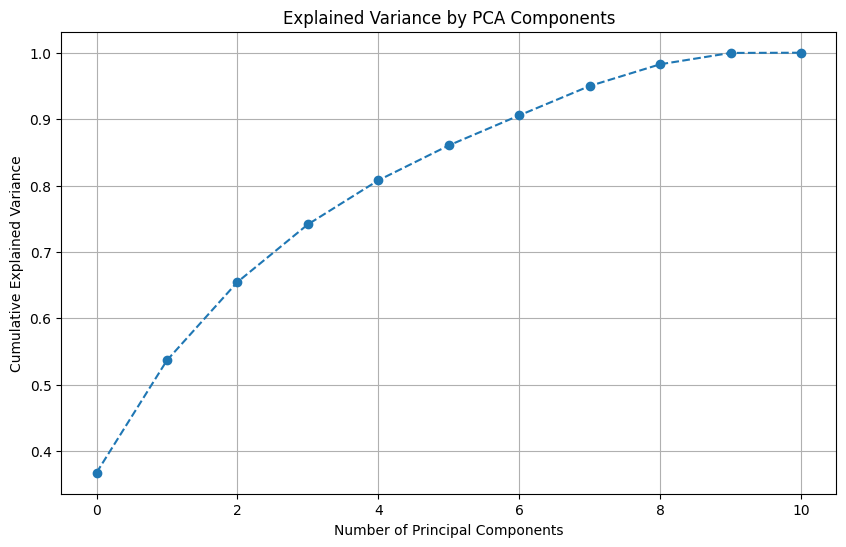

In [4]:
import numpy as np
import matplotlib.pyplot as plt


pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)



# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.savefig("all_pca_explained_variance.png", dpi=300, bbox_inches='tight')
plt.show()


In [5]:
# Retain enough components to explain 90% of variance
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Number of components selected:", pca.n_components_)


Number of components selected: 7


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train_pca, y_train)


y_pred = lr_model.predict(X_test_pca)
print("Linear Regression on PCA Components:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred):.4f}")


Linear Regression on PCA Components:
Mean Squared Error: 10.2248
R^2 Score: 0.8442


In [7]:
from xgboost import XGBRegressor


xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_pca, y_train)


y_pred = xgb_model.predict(X_test_pca)
print("XGBoost on PCA Components:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred):.4f}")


XGBoost on PCA Components:
Mean Squared Error: 9.4754
R^2 Score: 0.8556


In [8]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score


catboost_pca_model = CatBoostRegressor(random_seed=42, verbose=0)


catboost_pca_model.fit(X_train_pca, y_train)

y_pred_pca_catboost = catboost_pca_model.predict(X_test_pca)

print("CatBoost on PCA Components:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_pca_catboost):.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred_pca_catboost):.4f}")


CatBoost on PCA Components:
Mean Squared Error: 7.5519
R^2 Score: 0.8849


<Figure size 1000x800 with 0 Axes>

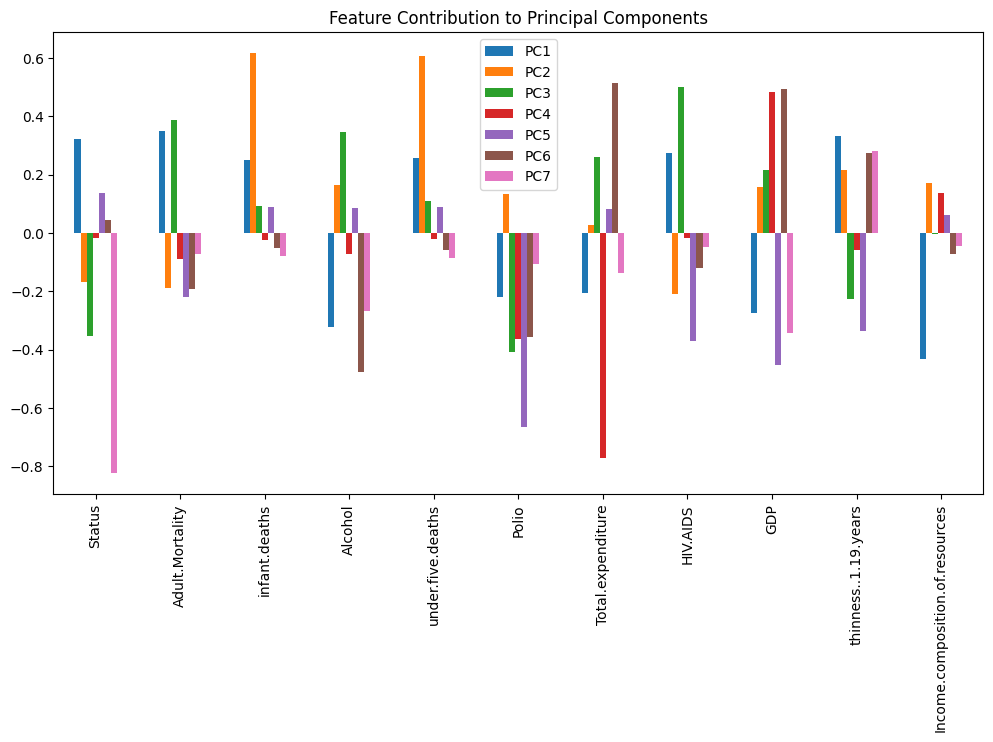

In [9]:

loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=features)


plt.figure(figsize=(10, 8))
loadings.plot(kind='bar', figsize=(12, 6), legend=True)
plt.title("Feature Contribution to Principal Components")
plt.savefig("feature_contributions_to_pcs.png", dpi=300, bbox_inches='tight')
plt.show()


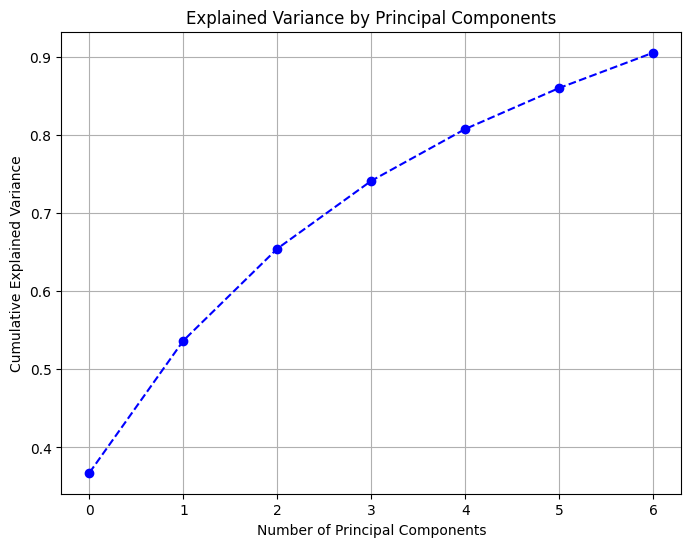

In [10]:
# Cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.grid(True)
plt.savefig("6_pca_explained_variance.png", dpi=300, bbox_inches='tight')
plt.show()


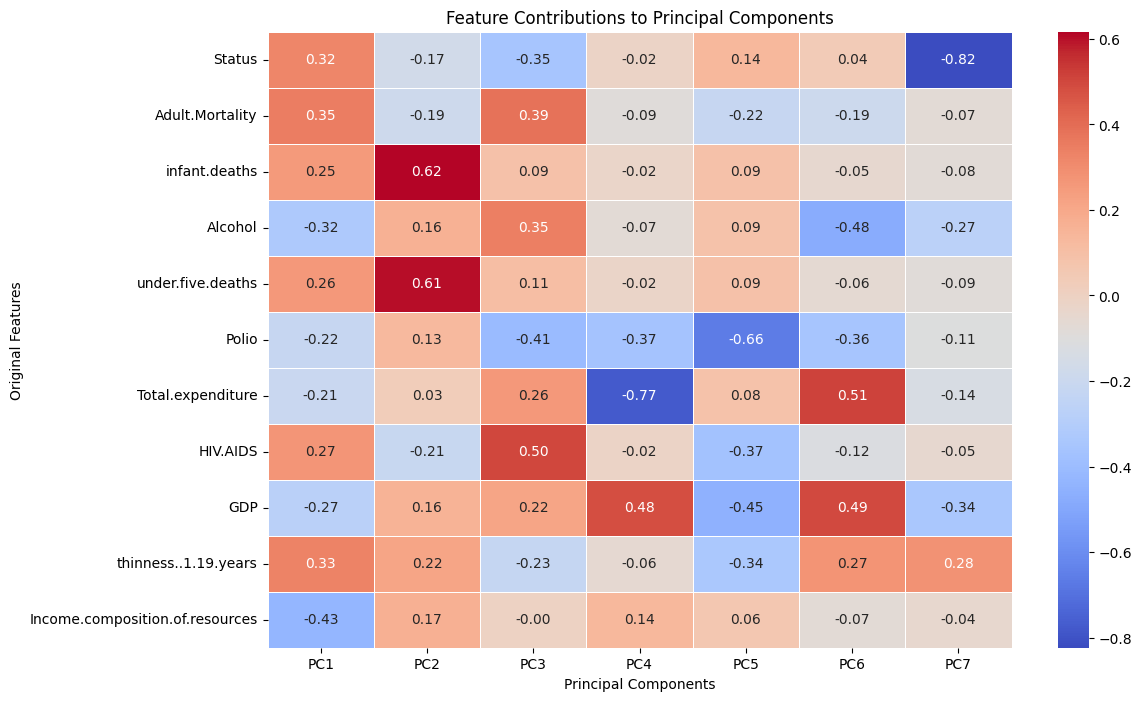

In [11]:
#Feature contributions heatmapo
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Contributions to Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Original Features")
plt.savefig("pca_feature_contribution_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


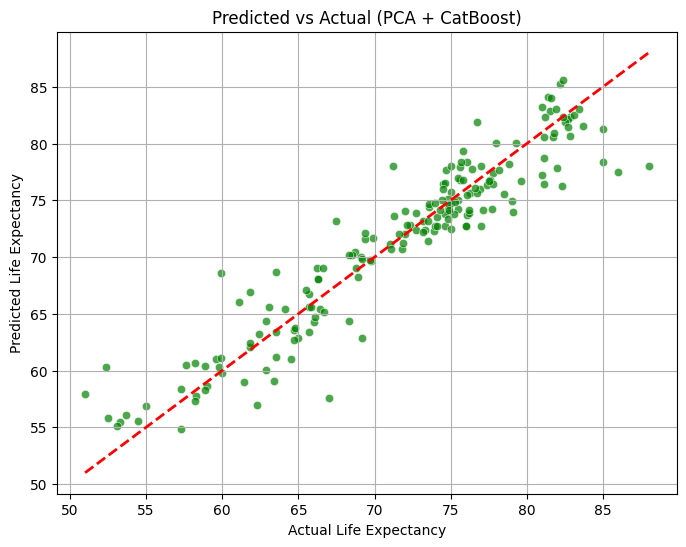

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_pca_catboost, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Predicted vs Actual (PCA + CatBoost)")
plt.grid(True)
plt.savefig("pca_catboost_predicted_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()


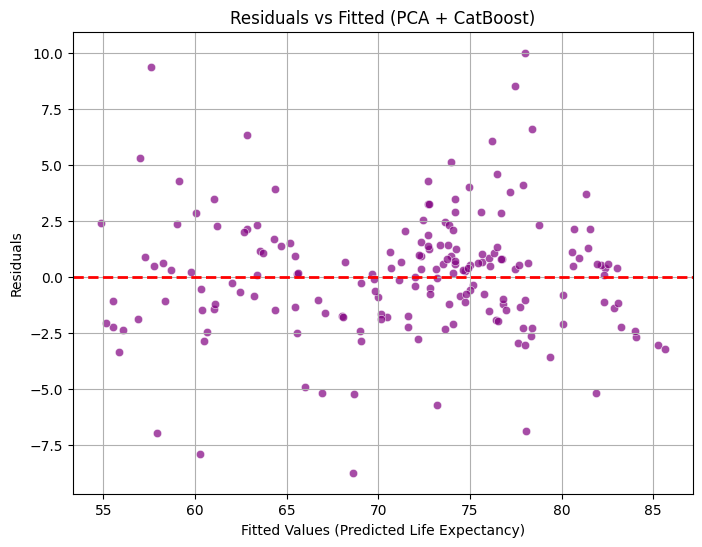

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


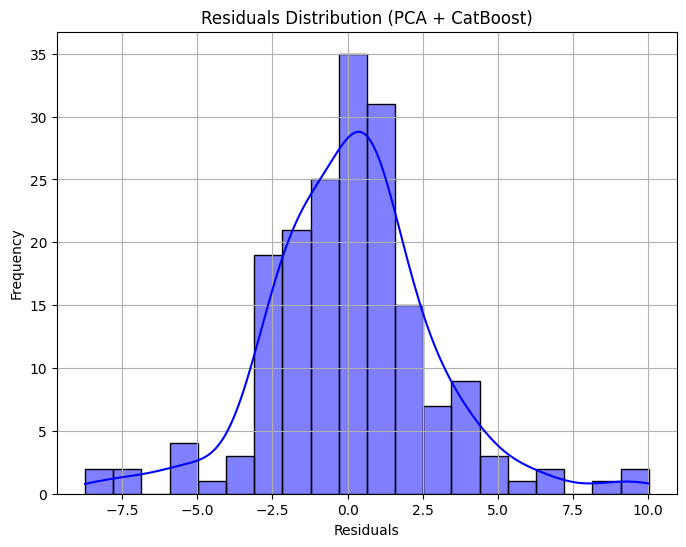

In [13]:
residuals_pca = y_test - y_pred_pca_catboost

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_pca_catboost, y=residuals_pca, alpha=0.7, color='purple')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values (Predicted Life Expectancy)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (PCA + CatBoost)")
plt.grid(True)
plt.savefig("pca_catboost_residuals_vs_fitted.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(residuals_pca, kde=True, bins=20, color="blue")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (PCA + CatBoost)")
plt.grid(True)
plt.savefig("pca_catboost_residual_histogram.png", dpi=300, bbox_inches='tight')
plt.show()
